Q1


##Get the device information

In [ ]:
import torch
torch.cuda.get_device_name(device=None)

'Tesla T4'

#Load required libraries

In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt


Data loading and Preprocessing.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Dataset/Assignment3_dataset/Assignment3_dataset2'

from torchvision import datasets, transforms
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64,64)),  # Resize images to a common size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root= path, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 114
    Root location: /content/drive/MyDrive/Dataset/Assignment3_dataset/Assignment3_dataset2
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
print(dataset[0])

(tensor([[[0.6314, 0.6392, 0.6471,  ..., 0.6118, 0.6039, 0.6000],
         [0.6314, 0.6431, 0.6471,  ..., 0.6078, 0.6039, 0.6000],
         [0.6353, 0.6431, 0.6510,  ..., 0.6078, 0.6000, 0.5961],
         ...,
         [0.1608, 0.1059, 0.1059,  ..., 0.4510, 0.4353, 0.4235],
         [0.0392, 0.0392, 0.0431,  ..., 0.4392, 0.4392, 0.4353],
         [0.0471, 0.0510, 0.0588,  ..., 0.4392, 0.4275, 0.4275]],

        [[0.3529, 0.3569, 0.3608,  ..., 0.3373, 0.3333, 0.3255],
         [0.3490, 0.3529, 0.3569,  ..., 0.3333, 0.3294, 0.3255],
         [0.3490, 0.3490, 0.3529,  ..., 0.3294, 0.3255, 0.3216],
         ...,
         [0.0980, 0.0667, 0.0667,  ..., 0.2588, 0.2549, 0.2510],
         [0.0353, 0.0392, 0.0392,  ..., 0.2471, 0.2471, 0.2471],
         [0.0431, 0.0510, 0.0549,  ..., 0.2510, 0.2431, 0.2431]],

        [[0.0902, 0.0902, 0.0941,  ..., 0.0980, 0.0980, 0.0941],
         [0.0863, 0.0863, 0.0902,  ..., 0.0941, 0.0941, 0.0902],
         [0.0824, 0.0863, 0.0863,  ..., 0.0863, 0.0902, 0

In [ ]:
classes = dataset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 1
Class Names :
 ['boat']


## Preserve only a few samples with a particular class label boat

In [ ]:
# Get indices for boat class
def get_indices(dataset, target_class=0):
    indices = [i for i in range(len(dataset.targets)) if dataset.targets[i] == target_class]
    return indices

# Get indices for the boat class
boat_indices = get_indices(dataset, target_class=0)
print('Num Train Samples with labels:', len(boat_indices))

# Split indices into training and validation
split_ratio = 0.9
split_index = int(split_ratio * len(boat_indices))
train_indices = boat_indices[:split_index]
val_indices = boat_indices[split_index:]

# Set up data loaders for training and validation
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.sampler.SubsetRandomSampler(val_indices))


Num Train Samples with labels: 114


In [ ]:
dataIter = iter(train_loader)
imgs, labels = next(dataIter)

In [ ]:
#visualization of data on a grid
def imshow_RGB(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    imgs = imgs.cpu()
    npimgs = imgs.numpy()
    imgs[0] = imgs[0] * 0.2023 + 0.4914
    imgs[1] = imgs[1] * 0.1994 + 0.4822
    imgs[2] = imgs[2] * 0.2010 + 0.4465
    plt.figure(figsize=(8,8))
    T = torchvision.transforms.Resize((32,32))
    imgs = T(imgs)
    plt.imshow(np.transpose(npimgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


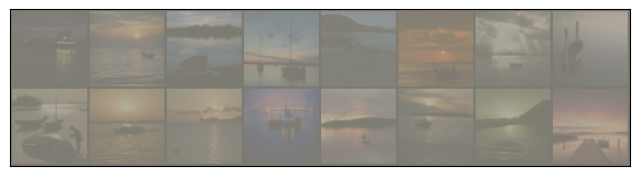

In [ ]:
imshow_RGB(imgs) #using imshow() to obtain the grid

#**DCGAN**
![Generative Adversarial Network](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Q1.a

## Create DC GAN Generator

In [ ]:
# Generator Code
nc = 3  # Number of channels in the training images. For color images this is 3
nz = 100  # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator

class DC_Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_G = DC_Gen()

## Create DC GAN Discriminator

In [ ]:
#Discriminator Code
ndf = 64  # Size of feature maps in discriminator

class DC_Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input)

In [ ]:
DC_D = DC_Dis()

In [ ]:
if (torch.cuda.is_available()):
    DC_D.cuda()
    DC_G.cuda()

print(DC_G)
print(DC_D)

DC_Gen(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
DC

1c

## Set up learning rate and optimizers for generator and discriminator

In [ ]:
lr = 1e-3  #learning rate
#optimizers for both models
G_opt = opt.Adam(DC_G.parameters(), lr=lr)
D_opt = opt.Adam(DC_D.parameters(), lr=lr)

1b

## Training module for DC GAN Architecture

Epoch:0,   G_loss:10.734951359885079,    D_loss:0.29761078474777086
Validation - Epoch:0,   G_loss:1.6734308004379272,    D_loss:1.1531128883361816


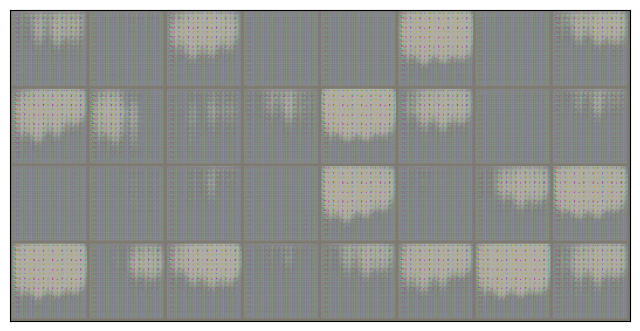

Epoch:1,   G_loss:9.97408138002668,    D_loss:0.4955434337524431
Validation - Epoch:1,   G_loss:8.373451232910156,    D_loss:0.5641958117485046
Epoch:2,   G_loss:8.842400755201067,    D_loss:0.19824623620869325
Validation - Epoch:2,   G_loss:8.401716232299805,    D_loss:0.7392047643661499
Epoch:3,   G_loss:10.160968371800013,    D_loss:0.07136038810546909
Validation - Epoch:3,   G_loss:7.439475059509277,    D_loss:0.2060900330543518
Epoch:4,   G_loss:9.322364943368095,    D_loss:0.013361993661549474
Validation - Epoch:4,   G_loss:5.818305492401123,    D_loss:0.8043912649154663
Epoch:5,   G_loss:6.644235815320696,    D_loss:0.04876422695815563
Validation - Epoch:5,   G_loss:6.1124372482299805,    D_loss:0.005936072673648596
Epoch:6,   G_loss:8.237247603280204,    D_loss:0.0836691235059074
Validation - Epoch:6,   G_loss:2.227991819381714,    D_loss:0.9433448910713196
Epoch:7,   G_loss:14.252731323242188,    D_loss:0.20408439718968502
Validation - Epoch:7,   G_loss:17.311838150024414,    

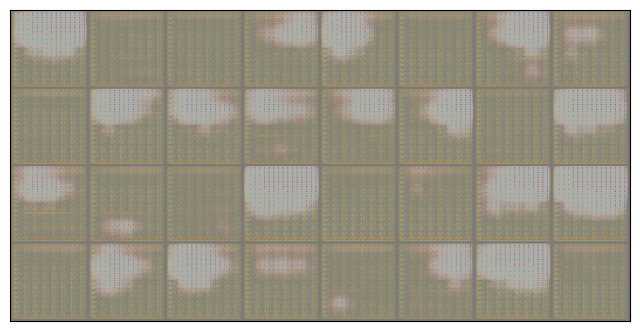

Epoch:11,   G_loss:10.562776429312569,    D_loss:0.12382006854750216
Validation - Epoch:11,   G_loss:2.700930118560791,    D_loss:0.579177975654602
Epoch:12,   G_loss:17.852284703935897,    D_loss:0.4026366054040409
Validation - Epoch:12,   G_loss:16.0226993560791,    D_loss:0.0015342605765908957
Epoch:13,   G_loss:9.871637957436699,    D_loss:0.037257880600269085
Validation - Epoch:13,   G_loss:6.836305618286133,    D_loss:0.05122898891568184
Epoch:14,   G_loss:6.528945105416434,    D_loss:0.2333229599254472
Validation - Epoch:14,   G_loss:7.193525314331055,    D_loss:0.03425135463476181
Epoch:15,   G_loss:7.295264652797154,    D_loss:0.207478198222816
Validation - Epoch:15,   G_loss:8.787240982055664,    D_loss:0.05318326875567436
Epoch:16,   G_loss:9.516232149941581,    D_loss:0.5341687752599162
Validation - Epoch:16,   G_loss:8.291248321533203,    D_loss:0.6079326868057251
Epoch:17,   G_loss:11.49399437223162,    D_loss:0.46842649951577187
Validation - Epoch:17,   G_loss:5.51177692

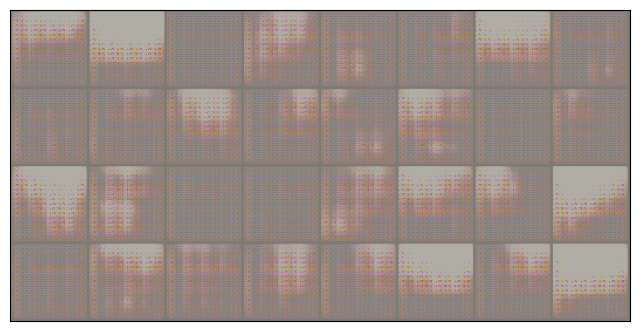

Epoch:21,   G_loss:8.166262558528356,    D_loss:0.5471901848380055
Validation - Epoch:21,   G_loss:4.89494514465332,    D_loss:0.16289196908473969
Epoch:22,   G_loss:7.215814454214914,    D_loss:0.07126720835055624
Validation - Epoch:22,   G_loss:6.726720809936523,    D_loss:0.12979276478290558
Epoch:23,   G_loss:7.930281979697091,    D_loss:0.09528673360390323
Validation - Epoch:23,   G_loss:6.7281012535095215,    D_loss:0.05103631317615509
Epoch:24,   G_loss:7.856429985591343,    D_loss:0.07210278963404042
Validation - Epoch:24,   G_loss:5.4567084312438965,    D_loss:0.01995900273323059
Epoch:25,   G_loss:8.524568285260882,    D_loss:0.1324331680578845
Validation - Epoch:25,   G_loss:5.113877296447754,    D_loss:0.06535536050796509
Epoch:26,   G_loss:14.324357645852226,    D_loss:0.2555760694667697
Validation - Epoch:26,   G_loss:14.322471618652344,    D_loss:0.00034850009251385927
Epoch:27,   G_loss:12.283246517181396,    D_loss:0.005068257116363384
Validation - Epoch:27,   G_loss:4

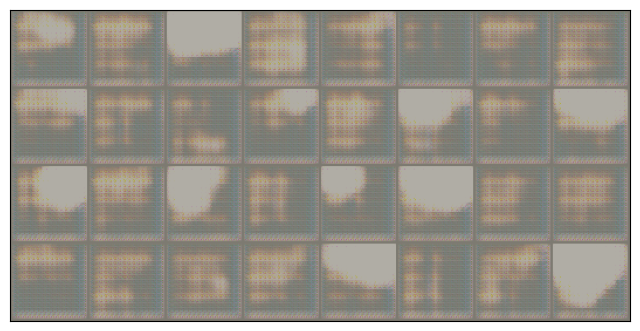

Epoch:31,   G_loss:7.8035206113542825,    D_loss:0.20368850550481252
Validation - Epoch:31,   G_loss:1.8439511060714722,    D_loss:1.113727331161499
Epoch:32,   G_loss:10.955074105943952,    D_loss:0.23928861346627986
Validation - Epoch:32,   G_loss:6.462480545043945,    D_loss:0.011970852501690388
Epoch:33,   G_loss:8.412539890834264,    D_loss:0.2652275912862803
Validation - Epoch:33,   G_loss:2.1340126991271973,    D_loss:0.574019730091095
Epoch:34,   G_loss:11.052393742970057,    D_loss:0.38259471870592926
Validation - Epoch:34,   G_loss:10.361228942871094,    D_loss:0.038577426224946976
Epoch:35,   G_loss:7.6665327208382745,    D_loss:0.046963463055102954
Validation - Epoch:35,   G_loss:5.889344692230225,    D_loss:0.08972779661417007
Epoch:36,   G_loss:7.518163681030273,    D_loss:0.05278369638004473
Validation - Epoch:36,   G_loss:4.397878646850586,    D_loss:0.32327374815940857
Epoch:37,   G_loss:7.249336242675781,    D_loss:0.2308352908917836
Validation - Epoch:37,   G_loss:5.

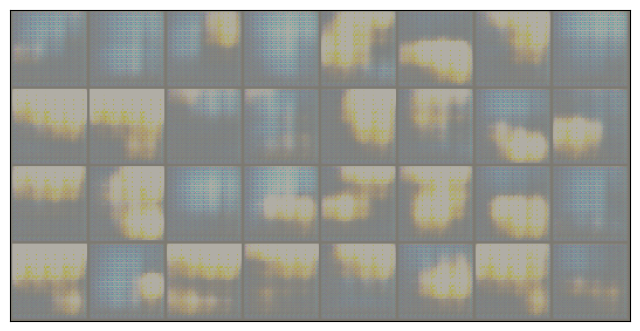

Epoch:41,   G_loss:8.490718569074359,    D_loss:0.3231462145756398
Validation - Epoch:41,   G_loss:7.00900411605835,    D_loss:0.1342400163412094
Epoch:42,   G_loss:7.648705754961286,    D_loss:0.14341837939407145
Validation - Epoch:42,   G_loss:2.8370699882507324,    D_loss:0.40081626176834106
Epoch:43,   G_loss:7.9542015961238315,    D_loss:0.6017682552337646
Validation - Epoch:43,   G_loss:8.242443084716797,    D_loss:0.197957381606102
Epoch:44,   G_loss:7.734583650316511,    D_loss:0.1115562128169196
Validation - Epoch:44,   G_loss:2.5348010063171387,    D_loss:0.6345973014831543
Epoch:45,   G_loss:5.995797089168003,    D_loss:0.35409126962934223
Validation - Epoch:45,   G_loss:5.718337059020996,    D_loss:0.4016522765159607
Epoch:46,   G_loss:6.908584662846157,    D_loss:0.12105032961283411
Validation - Epoch:46,   G_loss:4.761172771453857,    D_loss:0.9081026315689087
Epoch:47,   G_loss:10.342327799115862,    D_loss:0.12749324419668742
Validation - Epoch:47,   G_loss:5.3074584007

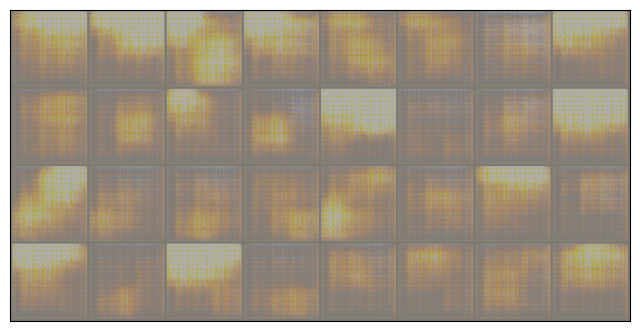

Epoch:51,   G_loss:11.102131707327706,    D_loss:0.1995821049703019
Validation - Epoch:51,   G_loss:15.390344619750977,    D_loss:0.5361248254776001
Epoch:52,   G_loss:14.759414196014404,    D_loss:0.2165826871246931
Validation - Epoch:52,   G_loss:15.9840726852417,    D_loss:0.5817719101905823
Epoch:53,   G_loss:13.764064175742012,    D_loss:0.17218895429479225
Validation - Epoch:53,   G_loss:3.191615581512451,    D_loss:1.2465664148330688
Epoch:54,   G_loss:10.045668533870153,    D_loss:0.43921348372740404
Validation - Epoch:54,   G_loss:7.836526393890381,    D_loss:0.19830232858657837
Epoch:55,   G_loss:9.0926787512643,    D_loss:0.13207999879627355
Validation - Epoch:55,   G_loss:3.6462485790252686,    D_loss:0.13325902819633484
Epoch:56,   G_loss:9.446479490825109,    D_loss:0.7817276939749718
Validation - Epoch:56,   G_loss:6.032321453094482,    D_loss:0.01764056831598282
Epoch:57,   G_loss:7.122984545571463,    D_loss:0.060112252698412964
Validation - Epoch:57,   G_loss:11.28087

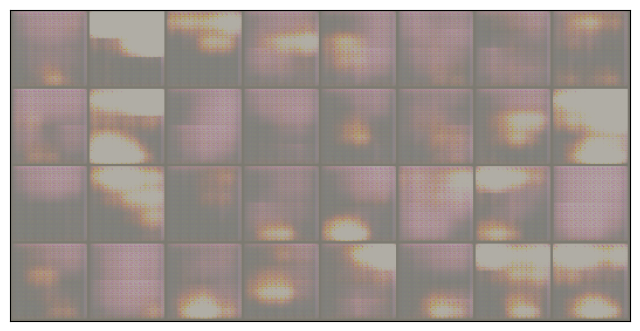

Epoch:61,   G_loss:8.970878635134016,    D_loss:0.4174167029559612
Validation - Epoch:61,   G_loss:11.895732879638672,    D_loss:0.38329896330833435
Epoch:62,   G_loss:16.93667984008789,    D_loss:0.10737854159898623
Validation - Epoch:62,   G_loss:7.9473395347595215,    D_loss:0.33502787351608276
Epoch:63,   G_loss:11.302895273481097,    D_loss:0.1629457315513199
Validation - Epoch:63,   G_loss:8.354683876037598,    D_loss:1.230776071548462
Epoch:64,   G_loss:10.178467886788505,    D_loss:0.15276239439845085
Validation - Epoch:64,   G_loss:10.066482543945312,    D_loss:1.3965181112289429
Epoch:65,   G_loss:9.276096820831299,    D_loss:0.08398711115920118
Validation - Epoch:65,   G_loss:9.468093872070312,    D_loss:0.5254881978034973
Epoch:66,   G_loss:9.148690973009382,    D_loss:0.11613738516877804
Validation - Epoch:66,   G_loss:8.287260055541992,    D_loss:0.9843010902404785
Epoch:67,   G_loss:10.01567540849958,    D_loss:0.10400254385811943
Validation - Epoch:67,   G_loss:6.514611

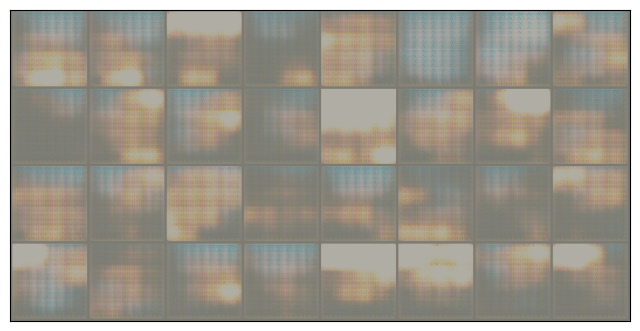

Epoch:71,   G_loss:7.524390629359654,    D_loss:1.2698528213160378
Validation - Epoch:71,   G_loss:3.2040209770202637,    D_loss:0.1421998143196106
Epoch:72,   G_loss:7.918281010219029,    D_loss:0.13002930408609764
Validation - Epoch:72,   G_loss:5.942838668823242,    D_loss:0.24527910351753235
Epoch:73,   G_loss:6.352491855621338,    D_loss:0.36280861789626734
Validation - Epoch:73,   G_loss:3.4852652549743652,    D_loss:0.677431046962738
Epoch:74,   G_loss:4.990851129804339,    D_loss:0.215843565762043
Validation - Epoch:74,   G_loss:1.419316053390503,    D_loss:1.1361620426177979
Epoch:75,   G_loss:6.097913878304618,    D_loss:0.3322561939379999
Validation - Epoch:75,   G_loss:6.198123455047607,    D_loss:1.7200043201446533
Epoch:76,   G_loss:8.651080914906093,    D_loss:0.49762903792517527
Validation - Epoch:76,   G_loss:13.12983226776123,    D_loss:1.5605449676513672
Epoch:77,   G_loss:6.93565491267613,    D_loss:0.24343457112887076
Validation - Epoch:77,   G_loss:6.1858611106872

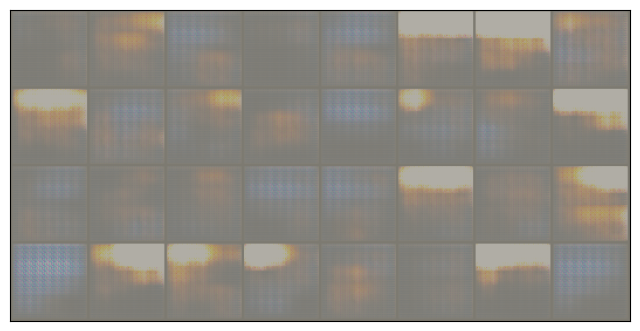

Epoch:81,   G_loss:6.638519355228969,    D_loss:0.11237251119954246
Validation - Epoch:81,   G_loss:4.8185882568359375,    D_loss:0.187530055642128
Epoch:82,   G_loss:7.276343958718436,    D_loss:0.050121224618383815
Validation - Epoch:82,   G_loss:4.347681045532227,    D_loss:0.11410492658615112
Epoch:83,   G_loss:6.222304613994701,    D_loss:0.34893806571406977
Validation - Epoch:83,   G_loss:0.04929216206073761,    D_loss:4.296104907989502
Epoch:84,   G_loss:8.594651971544538,    D_loss:1.458868337529046
Validation - Epoch:84,   G_loss:1.8201254606246948,    D_loss:1.3621495962142944
Epoch:85,   G_loss:7.573615482875279,    D_loss:0.4278560983283179
Validation - Epoch:85,   G_loss:3.980949878692627,    D_loss:0.8547885417938232
Epoch:86,   G_loss:5.839885439191546,    D_loss:0.33673478237220217
Validation - Epoch:86,   G_loss:2.4654695987701416,    D_loss:0.8689651489257812
Epoch:87,   G_loss:5.5566823823111395,    D_loss:0.6824586444667408
Validation - Epoch:87,   G_loss:1.90953445

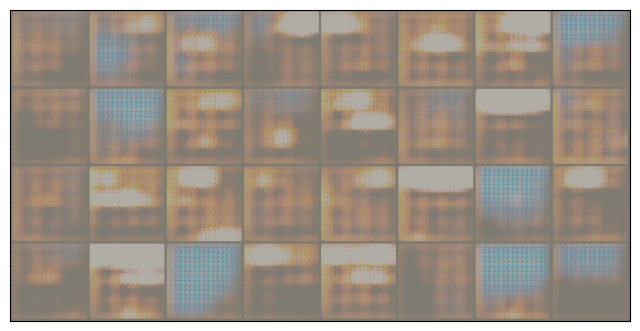

Epoch:91,   G_loss:7.0525504520961215,    D_loss:0.14124425314366817
Validation - Epoch:91,   G_loss:4.457643508911133,    D_loss:0.2145758420228958
Epoch:92,   G_loss:7.106706619262695,    D_loss:0.06887985340186528
Validation - Epoch:92,   G_loss:8.750518798828125,    D_loss:0.3854829967021942
Epoch:93,   G_loss:6.876156261989048,    D_loss:0.05752476677298546
Validation - Epoch:93,   G_loss:2.472623586654663,    D_loss:0.7322626113891602
Epoch:94,   G_loss:5.550123691558838,    D_loss:0.13265335506626538
Validation - Epoch:94,   G_loss:3.8249030113220215,    D_loss:0.5937960147857666
Epoch:95,   G_loss:5.221491200583322,    D_loss:0.19213718814509256
Validation - Epoch:95,   G_loss:4.618412017822266,    D_loss:0.7063427567481995
Epoch:96,   G_loss:5.954343523297991,    D_loss:0.3382891373974936
Validation - Epoch:96,   G_loss:3.605419158935547,    D_loss:0.9095059633255005
Epoch:97,   G_loss:7.961480924061367,    D_loss:0.7233705895154604
Validation - Epoch:97,   G_loss:11.488895416

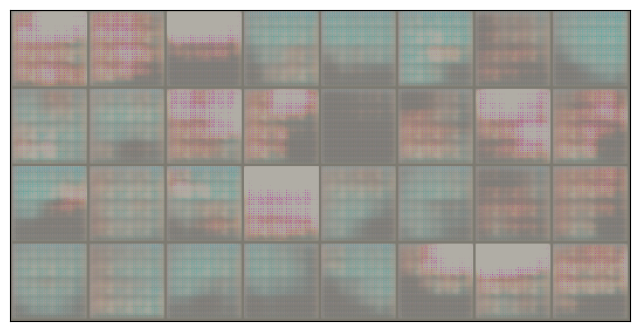

Epoch:101,   G_loss:8.849874155861992,    D_loss:0.22986056901780622
Validation - Epoch:101,   G_loss:11.070549011230469,    D_loss:0.1328164041042328
Epoch:102,   G_loss:8.314484391893659,    D_loss:0.22118635568767786
Validation - Epoch:102,   G_loss:1.1885936260223389,    D_loss:1.029195785522461
Epoch:103,   G_loss:8.30901847566877,    D_loss:0.7704700412494796
Validation - Epoch:103,   G_loss:2.4336466789245605,    D_loss:1.2366282939910889
Epoch:104,   G_loss:7.501640966960362,    D_loss:0.6126615639243808
Validation - Epoch:104,   G_loss:2.987018585205078,    D_loss:0.26870259642601013
Epoch:105,   G_loss:7.926192828587124,    D_loss:0.533412264926093
Validation - Epoch:105,   G_loss:6.443289756774902,    D_loss:0.02768765762448311
Epoch:106,   G_loss:11.001781736101423,    D_loss:0.2595172394067049
Validation - Epoch:106,   G_loss:7.584036827087402,    D_loss:0.006181673146784306
Epoch:107,   G_loss:7.017674241747175,    D_loss:0.17025056641016686
Validation - Epoch:107,   G_lo

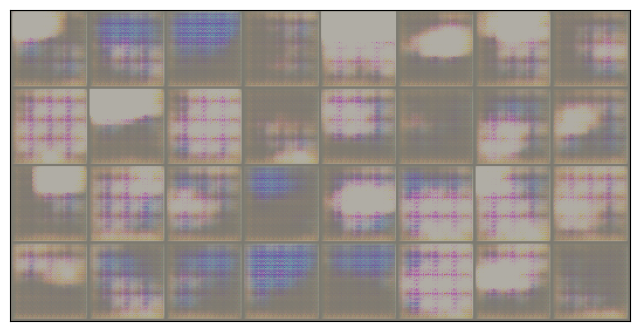

Epoch:111,   G_loss:8.298871789659772,    D_loss:0.09128463294889246
Validation - Epoch:111,   G_loss:5.529819011688232,    D_loss:0.1022849902510643
Epoch:112,   G_loss:7.77483252116612,    D_loss:0.1280918786568301
Validation - Epoch:112,   G_loss:7.347726345062256,    D_loss:0.574920117855072
Epoch:113,   G_loss:8.37388277053833,    D_loss:0.18677336616175516
Validation - Epoch:113,   G_loss:5.9162421226501465,    D_loss:0.8430378437042236
Epoch:114,   G_loss:10.139127595084053,    D_loss:0.3903503998049668
Validation - Epoch:114,   G_loss:8.67567253112793,    D_loss:0.2763228714466095
Epoch:115,   G_loss:14.892084462302071,    D_loss:0.4032494807615876
Validation - Epoch:115,   G_loss:1.7644380331039429,    D_loss:0.9005002975463867
Epoch:116,   G_loss:17.250454085213796,    D_loss:0.3170822315067718
Validation - Epoch:116,   G_loss:14.229022026062012,    D_loss:1.2978416681289673
Epoch:117,   G_loss:11.272379841123309,    D_loss:0.2258076697305244
Validation - Epoch:117,   G_loss:

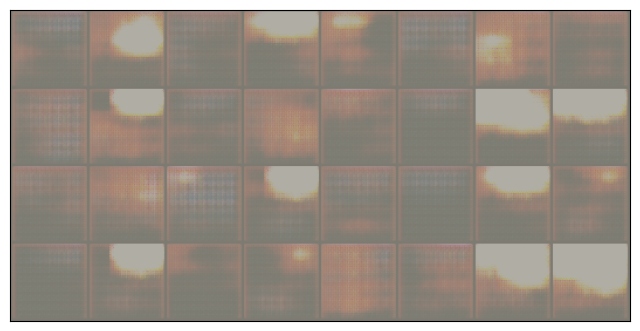

Epoch:121,   G_loss:8.932130404881068,    D_loss:0.3954679976616587
Validation - Epoch:121,   G_loss:5.871303558349609,    D_loss:0.050912145525217056
Epoch:122,   G_loss:7.269573484148298,    D_loss:0.15922103263437748
Validation - Epoch:122,   G_loss:7.591867446899414,    D_loss:0.2917415499687195
Epoch:123,   G_loss:6.71829468863351,    D_loss:0.18097031276140893
Validation - Epoch:123,   G_loss:7.561511039733887,    D_loss:0.4944148063659668
Epoch:124,   G_loss:7.132564953395298,    D_loss:0.17355040247951234
Validation - Epoch:124,   G_loss:6.348133087158203,    D_loss:0.37312018871307373
Epoch:125,   G_loss:6.936698641095843,    D_loss:0.23241510295442172
Validation - Epoch:125,   G_loss:6.60743522644043,    D_loss:0.7485711574554443
Epoch:126,   G_loss:8.88856588091169,    D_loss:0.04641047495949481
Validation - Epoch:126,   G_loss:5.105599880218506,    D_loss:0.309577077627182
Epoch:127,   G_loss:7.747526850019183,    D_loss:0.036769180808083286
Validation - Epoch:127,   G_loss

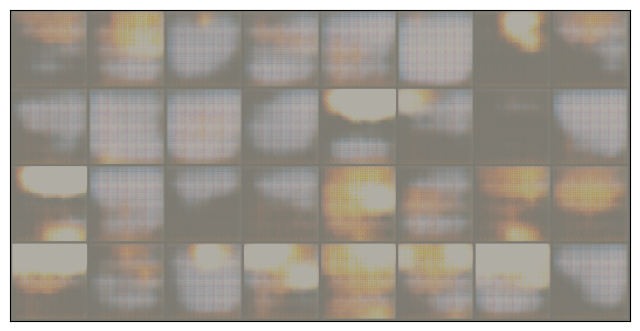

Epoch:131,   G_loss:8.378984519413539,    D_loss:0.17732008546590805
Validation - Epoch:131,   G_loss:8.59359359741211,    D_loss:0.3852309584617615
Epoch:132,   G_loss:6.846415417534964,    D_loss:0.24693443200417928
Validation - Epoch:132,   G_loss:4.016236782073975,    D_loss:0.35288912057876587
Epoch:133,   G_loss:9.139532225472587,    D_loss:0.29308286202805384
Validation - Epoch:133,   G_loss:8.895103454589844,    D_loss:0.26013123989105225
Epoch:134,   G_loss:8.59889486857823,    D_loss:0.1935544359896864
Validation - Epoch:134,   G_loss:5.765632629394531,    D_loss:0.34858885407447815
Epoch:135,   G_loss:7.702576841626849,    D_loss:0.07280624365167958
Validation - Epoch:135,   G_loss:6.166010856628418,    D_loss:1.0279375314712524
Epoch:136,   G_loss:7.6730940001351495,    D_loss:0.2926290588719504
Validation - Epoch:136,   G_loss:10.833446502685547,    D_loss:1.385922908782959
Epoch:137,   G_loss:8.180567400796074,    D_loss:0.15366561018994876
Validation - Epoch:137,   G_los

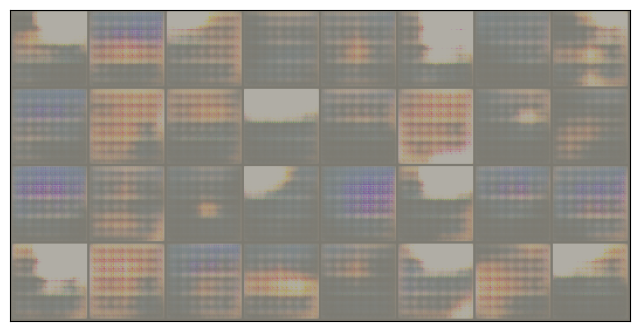

Epoch:141,   G_loss:6.886021886553083,    D_loss:0.11625157802232675
Validation - Epoch:141,   G_loss:6.4206085205078125,    D_loss:0.02245544269680977
Epoch:142,   G_loss:6.760974475315639,    D_loss:0.16589099168777466
Validation - Epoch:142,   G_loss:1.9921787977218628,    D_loss:1.0064923763275146
Epoch:143,   G_loss:6.3713944639478415,    D_loss:0.5049437236573014
Validation - Epoch:143,   G_loss:4.417612075805664,    D_loss:0.16916432976722717
Epoch:144,   G_loss:7.456647668566022,    D_loss:0.38630340567656923
Validation - Epoch:144,   G_loss:0.35509663820266724,    D_loss:2.1798906326293945
Epoch:145,   G_loss:6.652283276830401,    D_loss:0.7802682646683284
Validation - Epoch:145,   G_loss:3.0656046867370605,    D_loss:0.4637991786003113
Epoch:146,   G_loss:9.43726669039045,    D_loss:0.4351896263126816
Validation - Epoch:146,   G_loss:3.303788900375366,    D_loss:0.6166494488716125
Epoch:147,   G_loss:9.074824265071324,    D_loss:0.5824217019336564
Validation - Epoch:147,   G_

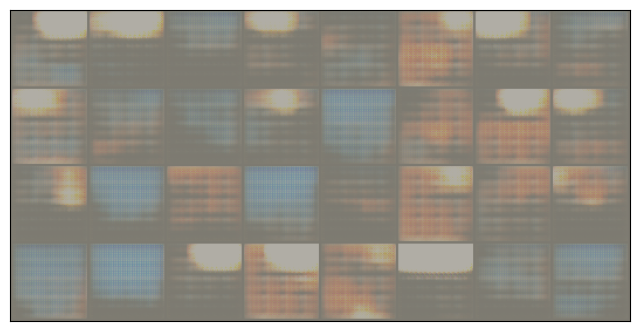

Epoch:151,   G_loss:5.452427864074707,    D_loss:0.15773964460406983
Validation - Epoch:151,   G_loss:4.281193733215332,    D_loss:0.27828606963157654
Epoch:152,   G_loss:5.449671404702323,    D_loss:0.42322177972112385
Validation - Epoch:152,   G_loss:3.0813417434692383,    D_loss:0.2854258418083191
Epoch:153,   G_loss:6.7583809580121725,    D_loss:0.19905652850866318
Validation - Epoch:153,   G_loss:7.56561803817749,    D_loss:0.007545298896729946
Epoch:154,   G_loss:5.359873226710728,    D_loss:0.0969566081517509
Validation - Epoch:154,   G_loss:8.628958702087402,    D_loss:0.0005038041854277253
Epoch:155,   G_loss:9.567028181893486,    D_loss:0.05222440214960703
Validation - Epoch:155,   G_loss:12.099515914916992,    D_loss:0.18350325524806976
Epoch:156,   G_loss:7.887813942773001,    D_loss:0.137927495076188
Validation - Epoch:156,   G_loss:5.490395545959473,    D_loss:0.04358585178852081
Epoch:157,   G_loss:6.638016087668283,    D_loss:0.06534005515277386
Validation - Epoch:157, 

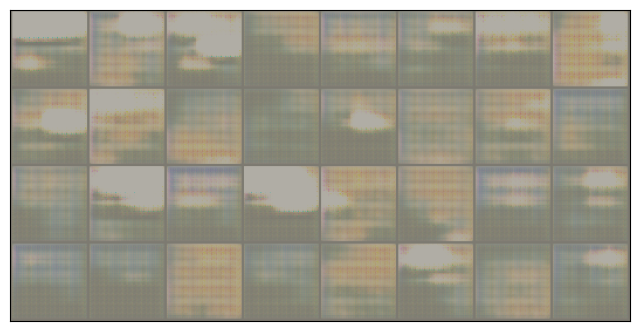

Epoch:161,   G_loss:7.396327495574951,    D_loss:0.17333092487284116
Validation - Epoch:161,   G_loss:4.283934116363525,    D_loss:0.5192551612854004
Epoch:162,   G_loss:6.32132761819022,    D_loss:0.23002836746828897
Validation - Epoch:162,   G_loss:10.088272094726562,    D_loss:1.7557337284088135
Epoch:163,   G_loss:7.782972063337054,    D_loss:0.3670116790703365
Validation - Epoch:163,   G_loss:7.839147090911865,    D_loss:1.4429278373718262
Epoch:164,   G_loss:7.844124589647565,    D_loss:0.2781847289630345
Validation - Epoch:164,   G_loss:6.213647365570068,    D_loss:0.7214052081108093
Epoch:165,   G_loss:6.965568814958845,    D_loss:0.20574354540024484
Validation - Epoch:165,   G_loss:6.437230587005615,    D_loss:0.722490668296814
Epoch:166,   G_loss:7.476203305380685,    D_loss:0.04297274337815387
Validation - Epoch:166,   G_loss:5.067668437957764,    D_loss:1.4140172004699707
Epoch:167,   G_loss:6.290616512298584,    D_loss:0.15877104923129082
Validation - Epoch:167,   G_loss:4

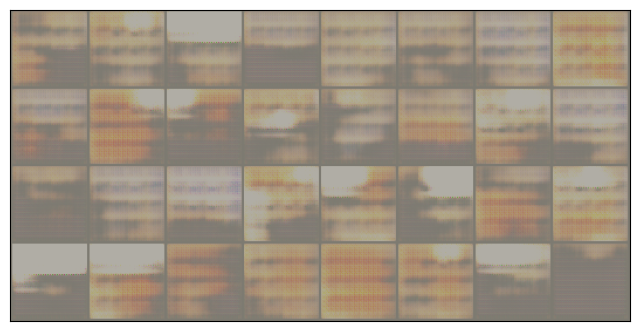

Epoch:171,   G_loss:7.7943709918430875,    D_loss:0.5503456549985069
Validation - Epoch:171,   G_loss:3.7825286388397217,    D_loss:0.7035300731658936
Epoch:172,   G_loss:10.486529418400355,    D_loss:0.25120591319033075
Validation - Epoch:172,   G_loss:10.946048736572266,    D_loss:0.27594640851020813
Epoch:173,   G_loss:8.581816468920026,    D_loss:0.26222630962729454
Validation - Epoch:173,   G_loss:7.289681434631348,    D_loss:0.3469431400299072
Epoch:174,   G_loss:8.078496388026647,    D_loss:0.23992122150957584
Validation - Epoch:174,   G_loss:9.361680030822754,    D_loss:0.1459737867116928
Epoch:175,   G_loss:7.244766848427909,    D_loss:0.6136948178921428
Validation - Epoch:175,   G_loss:1.8198213577270508,    D_loss:1.1654791831970215
Epoch:176,   G_loss:7.615650653839111,    D_loss:0.5133034629481179
Validation - Epoch:176,   G_loss:3.66119647026062,    D_loss:0.95369553565979
Epoch:177,   G_loss:5.936586209705898,    D_loss:0.6373472894941058
Validation - Epoch:177,   G_loss

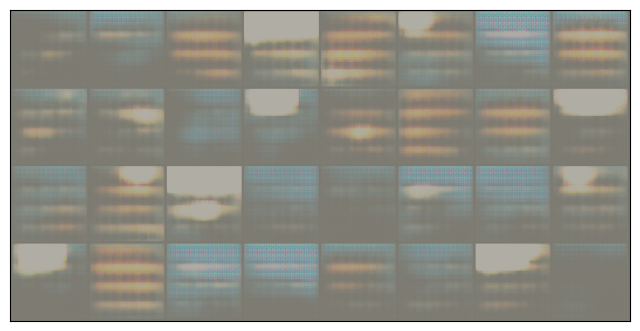

Epoch:181,   G_loss:6.376250267028809,    D_loss:0.11462162288704089
Validation - Epoch:181,   G_loss:6.816154479980469,    D_loss:1.3033292293548584
Epoch:182,   G_loss:6.382517508098057,    D_loss:0.17849505586283548
Validation - Epoch:182,   G_loss:2.7766833305358887,    D_loss:0.7391179800033569
Epoch:183,   G_loss:7.275532926831927,    D_loss:0.6449593425329242
Validation - Epoch:183,   G_loss:4.9259185791015625,    D_loss:0.11868912726640701
Epoch:184,   G_loss:7.9333792754582,    D_loss:0.38374202645250727
Validation - Epoch:184,   G_loss:1.5341861248016357,    D_loss:1.3450980186462402
Epoch:185,   G_loss:6.020046370370047,    D_loss:0.7091534808278084
Validation - Epoch:185,   G_loss:0.6797949075698853,    D_loss:1.886102318763733
Epoch:186,   G_loss:6.80640493120466,    D_loss:0.4579723136765616
Validation - Epoch:186,   G_loss:5.746005058288574,    D_loss:0.04756034165620804
Epoch:187,   G_loss:10.085374900272914,    D_loss:0.2078460037176098
Validation - Epoch:187,   G_loss

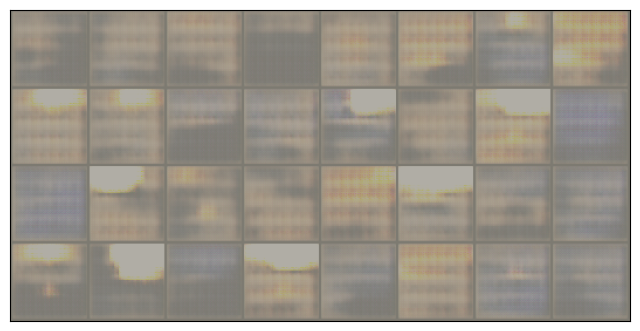

Epoch:191,   G_loss:8.730452128819056,    D_loss:0.3182392612631832
Validation - Epoch:191,   G_loss:4.174785614013672,    D_loss:0.6862338781356812
Epoch:192,   G_loss:8.336199828556605,    D_loss:0.12714277034891502
Validation - Epoch:192,   G_loss:2.0627379417419434,    D_loss:1.0864841938018799
Epoch:193,   G_loss:7.788748673030308,    D_loss:0.5316067636013031
Validation - Epoch:193,   G_loss:4.824748992919922,    D_loss:0.7744458317756653
Epoch:194,   G_loss:6.45392199925014,    D_loss:0.3725021045122828
Validation - Epoch:194,   G_loss:3.530470609664917,    D_loss:0.6670745015144348
Epoch:195,   G_loss:7.859085900442941,    D_loss:0.5514579213091305
Validation - Epoch:195,   G_loss:10.785684585571289,    D_loss:1.277390718460083
Epoch:196,   G_loss:5.936959743499756,    D_loss:0.28017302762184826
Validation - Epoch:196,   G_loss:2.777431011199951,    D_loss:0.7801321744918823
Epoch:197,   G_loss:6.777093410491943,    D_loss:0.15918173853840148
Validation - Epoch:197,   G_loss:2.

In [ ]:
from torch.autograd import Variable

G_losses = []
D_losses = []

best_G_loss = 0
best_D_loss = 0

real_label = 1.0
fake_label = 0.0

max_epochs = 200

for epoch in range(max_epochs):
    G_loss_run = 0.0
    D_loss_run = 0.0

    for i, data in enumerate(train_loader):
        X, _ = data  # labels of images are not very relevant
        batch_size = X.size(0)
        label = torch.full((batch_size,), real_label)
        label_f = torch.full((batch_size,), fake_label)

        z = torch.randn(batch_size, nz, 1, 1)
        fixed_noise = torch.randn(32, nz, 1, 1)

        if torch.cuda.is_available():
            X = X.cuda()
            label = label.cuda()
            z = z.cuda()
            label_f = label_f.cuda()
            fixed_noise = fixed_noise.cuda()

        ## DISCRIMINATOR TRAINING
        # train with real
        DC_D.zero_grad()

        D_real = DC_D(X)
        D_real = D_real.squeeze(1).squeeze(1).squeeze(1)
        D_real_loss = F.binary_cross_entropy(D_real, label)  # loss -(1/m)(log D(x))
        # D_real_loss.backward()

        # train with fake
        fake = DC_G(z)
        # label.fill(fake_label)
        D_fake = DC_D(fake.detach())
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        D_fake_loss = F.binary_cross_entropy(D_fake, label_f)  # loss -(1/m)(log(1-D(G(z))))

        D_loss = D_real_loss + D_fake_loss

        D_loss.backward()
        D_opt.step()

        # GENERATOR training
        D_fake = DC_D(fake)

        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        G_loss = F.binary_cross_entropy(D_fake, label)  # loss -(1/m)(log (1-D(G(z))))

        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()

    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run / (i + 1), D_loss_run / (i + 1)))

    G_losses.append(G_loss_run / (i + 1))
    D_losses.append(D_loss_run / (i + 1))

    # Validation loop
    G_val_loss = 0.0
    D_val_loss = 0.0

    for i, data in enumerate(val_loader):
        X, _ = data  # labels of images are not very relevant
        batch_size = X.size(0)
        label = torch.full((batch_size,), real_label)
        label_f = torch.full((batch_size,), fake_label)

        z = torch.randn(batch_size, nz, 1, 1)

        if torch.cuda.is_available():
            X = X.cuda()
            label = label.cuda()
            z = z.cuda()
            label_f = label_f.cuda()

        # Validation DISCRIMINATOR
        D_real = DC_D(X)
        D_real = D_real.squeeze(1).squeeze(1).squeeze(1)
        D_real_loss = F.binary_cross_entropy(D_real, label)

        fake = DC_G(z)
        D_fake = DC_D(fake.detach())
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        D_fake_loss = F.binary_cross_entropy(D_fake, label_f)

        D_val_loss += (D_real_loss + D_fake_loss).item()

        # Validation GENERATOR
        D_fake = DC_D(fake)
        D_fake = D_fake.squeeze(1).squeeze(1).squeeze(1)
        G_val_loss += F.binary_cross_entropy(D_fake, label).item()

    G_val_loss /= len(val_loader)
    D_val_loss /= len(val_loader)

    print('Validation - Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_val_loss, D_val_loss))

    if epoch % 10 == 0:
        with torch.no_grad():
            samples = DC_G(fixed_noise).detach()
            samples = samples.view(samples.size(0), 3, 64, 64)
            imshow_RGB(samples)

    # Save the models if they have better performance
    if G_val_loss < best_G_loss:
        best_G_loss = G_val_loss
        torch.save(DC_G.state_dict(), "best_DC_G.dth")

    if D_val_loss < best_D_loss:
        best_D_loss = D_val_loss
        torch.save(DC_D.state_dict(), "best_DC_D.dth")

# Saving the final model
print("Saving the final model state dictionary...at DC_G.dth and DC_D.dth")
torch.save(DC_G.state_dict(), "DC_G.dth")
torch.save(DC_D.state_dict(), "DC_D.dth")


1.e,d

1f,g

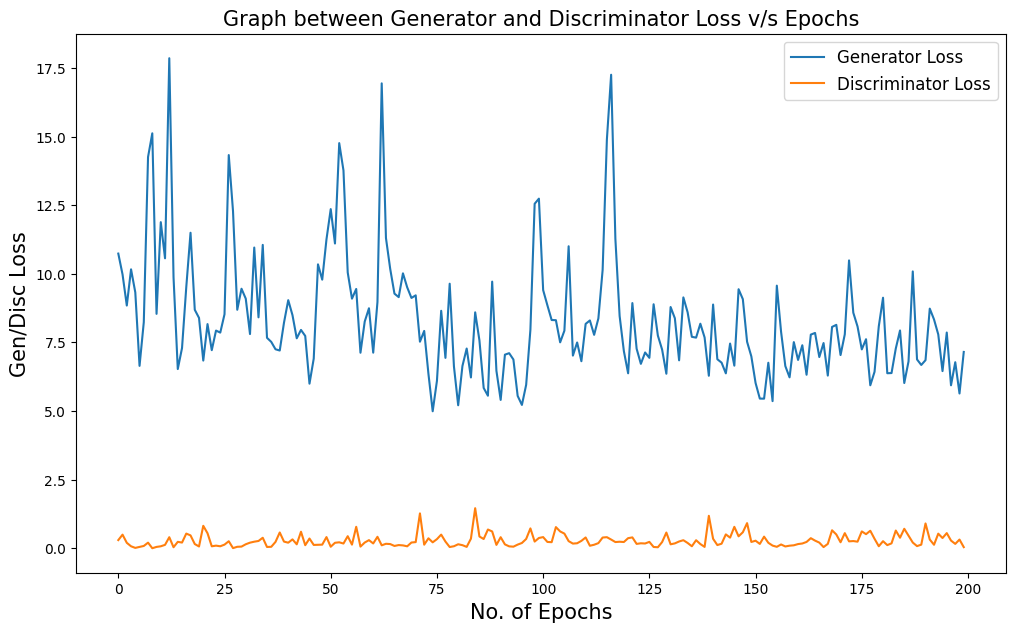

In [ ]:
#Plot losses
x_range = np.arange(0,max_epochs)
plt.figure(figsize =(12,7))
plt.plot(x_range,G_losses,label = "Generator Loss")
plt.plot(x_range,D_losses,label = "Discriminator Loss")
plt.ylabel("Gen/Disc Loss",fontsize = 15)
plt.xlabel("No. of Epochs",fontsize = 15)
plt.legend(fontsize = 12,loc = "best")
plt.title("Graph between Generator and Discriminator Loss v/s Epochs",fontsize = 15)
plt.show()


1.h,i

## Showing the generated images one last time

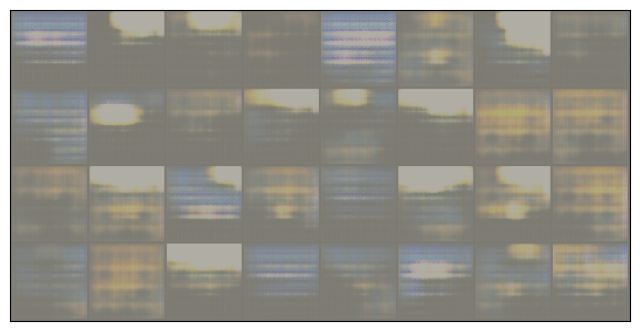

In [ ]:
fixed_noise = torch.randn(32, nz, 1, 1)
if torch.cuda.is_available():
  fixed_noise = fixed_noise.cuda()
with torch.no_grad():
    samples = DC_G(fixed_noise).detach()
    samples = samples.view(samples.size(0), 3, 64, 64)
    imshow_RGB(samples)

we can see a very blure image of boat in some of the images with the evening time in the background, the problem is the data given to us is hiding the fearures of boat for model to understand by the sunrise and sunset.